In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd
import json
import time
from textblob import TextBlob
 
#use time library in this way to get estimates of running times and other stuff like that.

In [2]:
with open("proj1_data.json") as fp:
    data = json.load(fp)   

In [3]:
df = pd.DataFrame(data)
# This part here is for new feature engineering, we'll test those out on the model performing best on the validation set later.

df['subjectivity'] = df.apply(lambda i : TextBlob(i.text).sentiment.subjectivity, axis=1)
df['cross'] = df.apply(lambda i : i.subjectivity * i.is_root *i.children, axis=1)


# lowercase and split on space
df['text'] = df['text'].str.lower().str.split()
# boolean to int
df['is_root'] = df.is_root.astype(int)
#isolate target value into a separate vector
y = df['popularity_score'].values
#drop the target value from the dataframe
df = df.drop(columns='popularity_score')

# for getting the most common words
topwords = {}

# count the words in the training set (first 10000 instances)
count = 0
for t in df.text:
    if count >= 10000:
        break
    count += 1
    for w in t:
        if w in topwords:
            topwords[w] += 1
        else:
            topwords[w] = 1           

In [4]:
#Use this function to get the three datasets using the top N most common words. If you put word_cout=0, then no words are used.
#Assignment baseline is 160, but at some point we must use 60 words
def trainTestSplitText(word_count):
    count = 0
    words = sorted(topwords, key=topwords.get, reverse=True)
    if(word_count!=0):
        for w in words:
            if count >= word_count:
                break
            count += 1
            df[w] = df.apply(lambda i : i.text.count(w), axis=1)

    dfNoTxt = df.drop(columns='text') #matrix with removed text column
    datamatrix = dfNoTxt.values #matrix of values
    # split into 3 matrices: first one is training, second is validation, third is testing
    matrixsets = np.split(datamatrix, [10000, 11000])
    #different sets
    return (matrixsets,words)

#The Mean squared error function
def mse(y_pred,y_true):
    return np.sum((y_pred-y_true)**2)/len(y_pred)

In [5]:
word_count = 60 #number of words used
matrixsets,words = trainTestSplitText(word_count)
x_train = matrixsets[0]
y_train = y[0:10000]
x_val = matrixsets[1] 
y_val = y[10000:11000]
x_test = matrixsets[2]
y_test = y[11000:12000]
#below we add the bias 1 columns to make our bias term
x_train = np.append(x_train.T,[np.ones(len(x_train))],axis=0).T
x_val = np.append(x_val.T,[np.ones(len(x_val))],axis=0).T
x_test = np.append(x_test.T,[np.ones(len(x_test))],axis=0).T

In [26]:
# This section here is for learning curves, can be ignored
train_error = []
val_error = []
size = []
i = 1
while (i<11): 
    index=1000*i
    x_interest = x_train[0:index]
    y_interest = y_train[0:index]
    weightsCF = np.matmul(np.linalg.inv(np.matmul(x_interest.T,x_interest)),np.matmul(x_interest.T,y_interest))
    pred_int = np.matmul(x_interest,weightsCF)
    pred_val = np.matmul(x_val,weightsCF)
    train_error= np.append(train_error,mse(pred_int,y_interest))
    val_error= np.append(val_error,mse(pred_val,y_val))
    size = np.append(size,index)
    i+=1
plt.figure(figsize=(18,12))
plt.plot(size,train_error, 'g', linewidth='8',label='Training error')
plt.plot(size,val_error,'k', linewidth='8',label='Validation error')
plt.xlabel('Size of training set (Number of instances used in training)', size='30')
plt.ylabel('MSE', size='30')
plt.tick_params(labelsize='30')
plt.grid()
plt.legend(loc=2,prop={'size': 20})

Below is the closed form solution. The bias weight was created by adding a row of 1's to the training instance matrix.

In [1]:
weightsCF = np.matmul(np.linalg.inv(np.matmul(x_train.T,x_train)),np.matmul(x_train.T,y_train))

NameError: name 'np' is not defined

In [9]:
predCF = np.matmul(x_val,weightsCF) #predictions for closed form weights
print(mse(predCF,y_val)) #this gives the mean squared error between the validation values and the predicted values
predTCF = np.matmul(x_train,weightsCF)
print(mse(predTCF,y_train))
predTest = np.matmul(x_test,weightsCF)
print(mse(predTest,y_test))

0.9784916534548159
1.0596284297001144


Below is the Gradient Descent solution

In [8]:
#The gradient descent function, can change learning rate initialization value, the epsilon stopping criteria and the starting weights
#by default if no starting weights are used they are normalized between -1 and 1
def gradientDescent(x,y,learning_rate_ini, epsilon, prev_weights=None):
    if(prev_weights is None):
        prev_weights = np.random.normal(loc= 0, scale=1, size=len(x[0])) #random generation between -1 and 1
        print(prev_weights)
    i = 1
    matmul_holder = np.matmul(x.T,x)
    matmul_holder2 = np.matmul(x.T,y)
    alpha = learning_rate_ini/ (1+i) #decaying learning rate 
    weights = prev_weights - 2*alpha*(np.matmul(matmul_holder,prev_weights) - matmul_holder2) #first weights
    while(np.linalg.norm(weights-prev_weights) > epsilon):
        alpha = learning_rate_ini/ (1+i)
        prev_weights = weights
        weights = prev_weights - 2*alpha*(np.matmul(matmul_holder,prev_weights) - matmul_holder2)
        i+=1
    
    return weights

In [14]:
start_time = time.time()
#learning_rate_ini = 1.45/len(x_train) #Divided by number of training instances as told by professor. Can be scaled
#epsilon = 0.00000007 #can be scaled, smaller epsilon than this one converges quite a bit slower. Need to scale it when testing.
learning_rate_ini = 1/len(x_train) #Divided by number of training instances as told by professor. Can be scaled
epsilon = 0.00000007 #can be scaled, smaller epsilon than this one converges quite a bit slower. Need to scale it when testing.
weightsGD = gradientDescent(x_train, y_train, learning_rate_ini, epsilon) #Gradient Descent is wrapped in this function
print("--- %s seconds ---" % (time.time() - start_time))

[ 0.11303952  0.01066077 -0.60794649  0.37171375  1.4879898   0.45646739
 -1.14887491 -1.8036754  -0.18086655  1.07442013 -0.60965712  1.14600819
 -1.5533162  -0.7190342   0.14718185 -1.58230982 -0.35925183  1.84097313
 -0.03176196 -0.15348282 -0.84110173  2.40901662 -0.22645599  0.74906826
  0.39188454  0.66983708  0.95099856  0.27221329 -0.3531337   1.73785868
  0.79230203 -0.78883569 -0.84612612  0.13227778  0.8936948   0.63516778
 -0.22894259 -0.41276069  0.37373896 -0.1255234   0.51154191 -0.84459772
  0.20078983  0.13831003  0.5383052  -1.72319565 -1.72111917  0.62623884
 -1.94488605 -0.84344069  2.24335757  1.0382826  -0.55686793 -0.40798556
 -2.27023144 -0.8033185   1.95973749  0.09420485  0.35598673 -0.58030831
  0.59804604 -0.10574995  0.24510351 -0.02352042  1.00519185]
--- 20.959657192230225 seconds ---


In [124]:
#the two weights for comparison
print(weightsCF)
print(weightsGD)

[ 3.73755813e-01 -1.06807964e+00 -2.36577896e-01 -9.20178205e-03
 -2.08035834e-02 -1.46121850e-02 -2.12712897e-02  1.25057105e-02
 -3.33629033e-03 -5.82413933e-02  5.42444765e-02  2.74005334e-02
  1.84596751e-02  1.57514227e-02 -4.73125082e-02  4.90693272e-02
  2.54562517e-02 -5.72239462e-02 -5.00976801e-02  5.00039665e-02
  6.24830543e-02  3.49798615e-02 -6.13611177e-03  2.81655339e-02
 -3.67849319e-02 -2.49394210e-02 -2.68923009e-02  3.34785743e-02
  7.20455786e-02  2.21709104e-02 -1.52196630e-02 -3.55448777e-03
  2.11746121e-02  3.88006782e-02 -2.86398153e-02  3.56525848e-02
 -1.69868837e-02  5.16153545e-02 -8.35170795e-02 -8.48067640e-04
  2.57158531e-02  1.49104247e-04 -2.93064700e-02 -1.18845551e-03
  5.69499078e-02  4.80045168e-02 -3.00720160e-02 -6.34895358e-02
  8.11247245e-02 -9.19339212e-03  3.32288539e-02  2.91681252e-02
  1.57835997e-02 -1.22389512e-02  6.16601858e-03 -5.32730345e-02
 -3.12166332e-02  4.52538094e-03 -3.41823323e-01  2.05517732e-03
 -3.42384927e-02 -2.08284

In [37]:
#Predictions
predGD = np.matmul(x_val,weightsGD)
predCF = np.matmul(x_val,weightsCF)
print(mse(predCF,y_val)) #this gives the mean squared error between the validation values and the predicted values
print(mse(predGD,y_val)) 
predTGD = np.matmul(x_train,weightsGD)
predTCF = np.matmul(x_train,weightsCF)
print(mse(predTCF,y_train))
print(mse(predTGD,y_train))

0.9843572574587265


0 words used results below

In [44]:
#closed form below
weightsCF1 = [ 0.37536403, -1.08584747, -0.22627679,  0.82092517]
mseTCF1 = 1.0846830709157251
mseVCF1 = 1.0203266
runtime = 0

#gradient descent below
weights1 = [ 0.3762454,  -1.18180814, -0.21451348,  0.81542066]
runtime1 = 1.86567
mseTGD1 = 1.0848284528771495
mseVGD1 = 1.0202028501083278
weights2 = [ 0.37237081,  0.18891373, -0.2109277,   0.79984237]
runtime2 = 8.5793
mseTGD2 = 1.1034495974039586
mseVGD2 = 1.038650065038471
weights3 = [ 0.37343284, -0.26928512, -0.21671745,  0.80757004]
runtime3 = 5.223
mseTGD3 = 1.0923826761186504
mseVGD3 = 1.0290793562064235
var=0.3246
#print(np.var([1.865,8.57,5.223]))
#print(np.var([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([mseTGD1,mseTGD2,mseTGD3]))
print(np.mean([1.865,8.57,5.223]))

1.0293107571177407
1.0935535754665862
5.219333333333334


60 words below

In [45]:
#closed form below
#weightsCF1 = weightsCF
mseTCF1 = 1.060429141685383
mseVCF1 = 0.9839397297217661
runtime= 0.0024 

#gradient descent below
runtime1 = 18.04
mseTGD1 = 1.1288544924339796
mseVGD1 = 1.1040700666994976
runtime2 = 15.96
mseTGD2 = 1.1237543492860382
mseVGD2 = 1.1246737433455476
runtime3 = 15.18
mseTGD3 = 1.1044306861578552
mseVGD3 = 1.0648792325754284
var= 0.13350
#print(np.var([runtime1,runtime2,runtime3]))
#print(np.var([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([runtime1,runtime2,runtime3]))
print(np.mean([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([mseTGD1,mseTGD2,mseTGD3]))
#np.linalg.norm(np.var([one,two,three],axis=0))

16.393333333333334
1.0978743475401578
1.119013175959291


160 words

In [46]:
#closed form below
#weightsCF1 = weightsCF
mseTCF1 = 1.0477763217987113
mseVCF1 = 0.9950693970669241
runtime = 0.13

#gradient descent below
runtime1 = 84
mseTGD1 = 1.2869191014208017
mseVGD1 = 1.4246445712220352
runtime2 = 86
mseTGD2 = 1.3181225263617042
mseVGD2 = 1.3555520701127874
runtime3 = 78
mseTGD3 = 1.24902381933571
mseVGD3 = 1.3101040873995533
#print(np.var([runtime1,runtime2,runtime3]))
#print(np.var([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([runtime1,runtime2,runtime3]))
print(np.mean([mseVGD1,mseVGD2,mseVGD3]))
print(np.mean([mseTGD1,mseTGD2,mseTGD3]))

82.66666666666667
1.363433576244792
1.2846884823727385


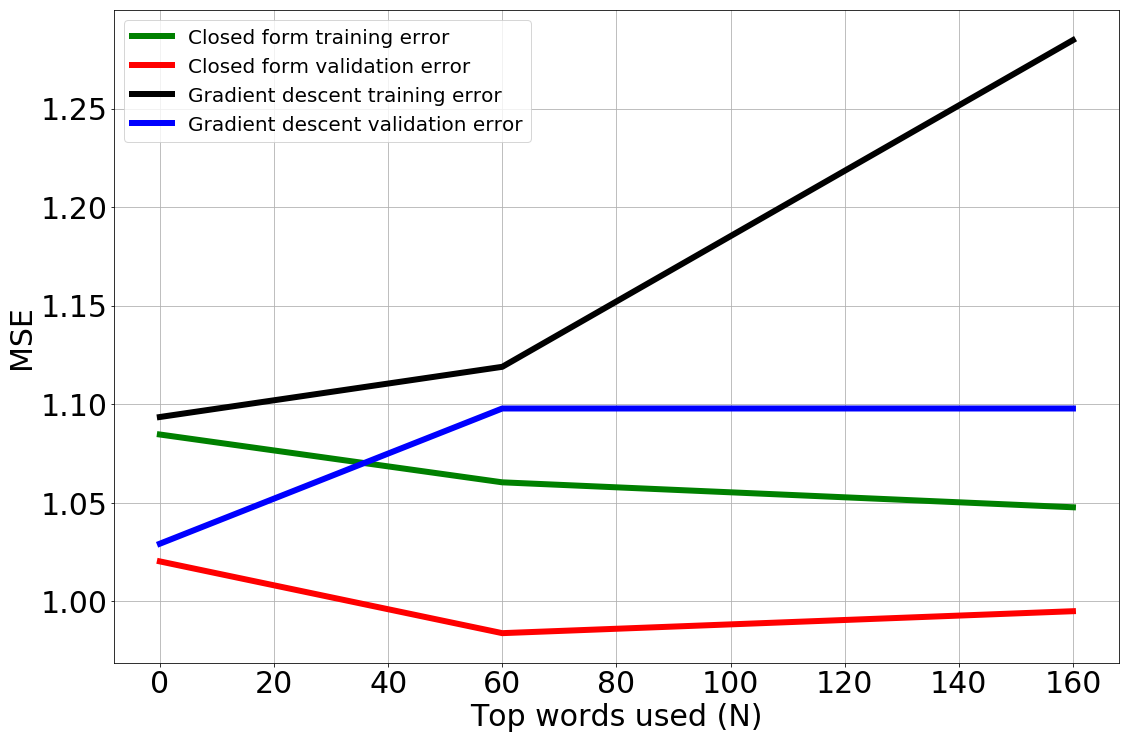

In [43]:
size = [0,60,160]
plt.figure(figsize=(18,12))
plt.plot(size, [1.0846830709157251,1.060429141685383,1.0477763217987113], 'g', linewidth='6',label='Closed form training error')
plt.plot(size, [1.0203266,0.9839397297217661,  0.9950693970669241],'r', linewidth='6',label='Closed form validation error')
plt.plot(size, [1.0935535754665862, 1.119013175959291, 1.2846884823727385], 'k', linewidth='6',label='Gradient descent training error')
plt.plot(size, [1.0293,1.0978743475401578,1.0978743475401578],'b', linewidth='6',label='Gradient descent validation error')
plt.ylabel('MSE', size='30')
plt.xlabel('Top words used (N)', size='30')
plt.tick_params(labelsize='30')
plt.grid()
plt.legend(loc=2,prop={'size': 20})

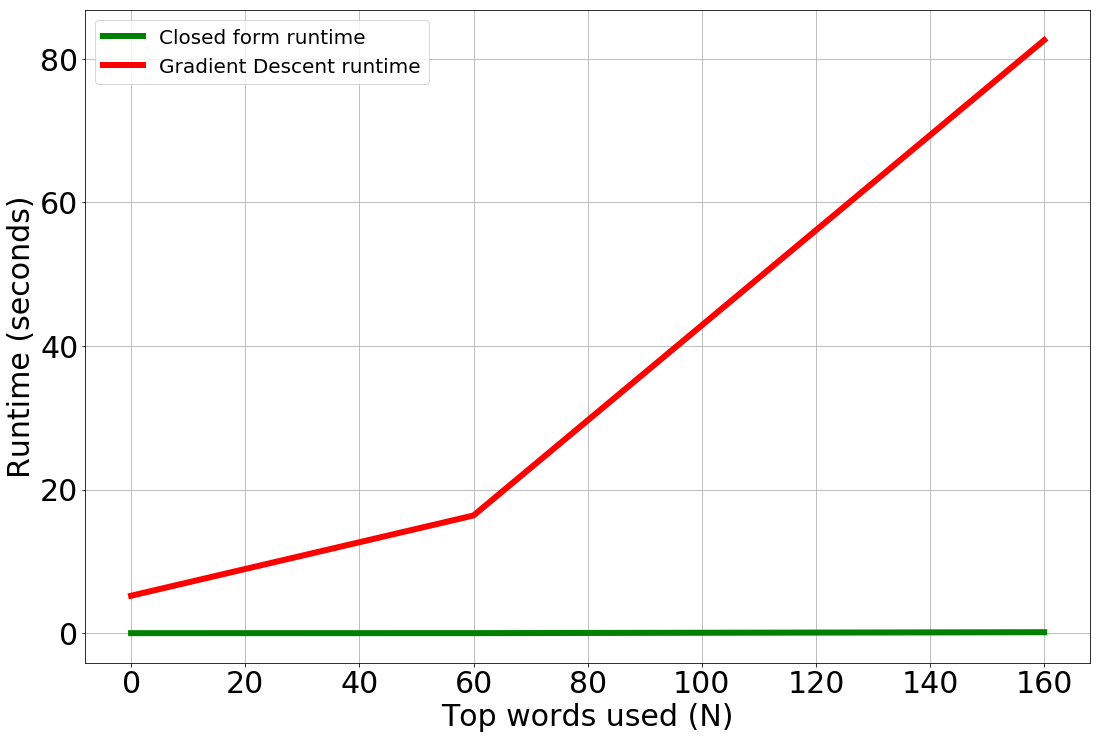

In [47]:
size = [0,60,160]
plt.figure(figsize=(18,12))
plt.plot(size,[0,0.0024, 0.13] , 'g', linewidth='6',label='Closed form runtime')
plt.plot(size, [5.21,16.39,82.6],'r', linewidth='6',label='Gradient Descent runtime')
plt.ylabel('Runtime (seconds)', size='30')
plt.xlabel('Top words used (N)', size='30')
plt.tick_params(labelsize='30')
plt.grid()
plt.legend(loc=2,prop={'size': 20})